In [28]:
import numpy as np
import utils.makeDataset as DatasetMaker
from utils.training import show_confusion_matrix, save_model, load_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os

MODEL_TYPE = "adaboost"
PATH_MODELS = f"../models/train_on_blocks/{MODEL_TYPE}/"
DATASETS = [16, 17]
MODEL_NAME = ''.join([str(MODEL_TYPE)] + ['_c' + str(curr) for curr in DATASETS])
FORCE_TRAIN_AGAIN = False  # Used to force the training of a model already exported

## Load data and split learning and testing data

In [29]:
X = []
y = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y += [current_dataset] * len(X_current)
    X += X_current

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Convert data to make classification on DCT blocks and not on the whole image

In [30]:
def convert(X, y):
    res_X = []
    res_y = []
    for curr_X, curr_y in zip(X, y):
        for block in curr_X:
            res_X.append(block.reshape(64))
            res_y.append(curr_y)
    return res_X, res_y


X_train_block, y_train_block = convert(X_train, y_train)
X_test_block, y_test_block = convert(X_test, y_test)

## Training or Loading existing model

In [31]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def get_trained_model(model):
    if not (os.path.exists(os.path.join(PATH_MODELS, MODEL_NAME + '.pickle'))) or FORCE_TRAIN_AGAIN:
        print(f"Training {MODEL_NAME}, please wait...")
        model.fit(X_train_block, y_train_block)
        print(f"Saving {MODEL_NAME} at {os.path.join(PATH_MODELS, MODEL_NAME)}.pickle")
        save_model(model, PATH_MODELS, MODEL_NAME)
    else:
        print(f"Loading {MODEL_NAME}, please wait...")
        model = load_model(PATH_MODELS, MODEL_NAME)
    return model


MODELS = {
    "rf": RandomForestClassifier(max_depth=2, random_state=0),
    "adaboost": AdaBoostClassifier(),
    "svm": make_pipeline(StandardScaler(), SVC(gamma='auto', probability=False))
}

In [32]:
model = get_trained_model(MODELS[MODEL_TYPE])

Loading adaboost_c16_c17, please wait...


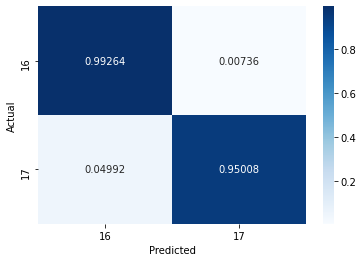

In [33]:
y_pred_block = model.predict(X_test_block)
show_confusion_matrix(y_test_block, y_pred_block, DATASETS)

In [34]:
print(classification_report(y_test_block, y_pred_block))

              precision    recall  f1-score   support

          16       0.95      0.99      0.97    147456
          17       0.99      0.95      0.97    144384

    accuracy                           0.97    291840
   macro avg       0.97      0.97      0.97    291840
weighted avg       0.97      0.97      0.97    291840



## Vote majoritaire

In [35]:
y_pred = []
for curr_X_test in X_test:
    curr_y_pred = model.predict(curr_X_test.reshape(curr_X_test.shape[0], curr_X_test.shape[1] * curr_X_test.shape[2]))
    unique, counts = np.unique(curr_y_pred, return_counts=True)
    y_pred.append(unique[np.argmax(counts)])

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          16       1.00      1.00      1.00        48
          17       1.00      1.00      1.00        47

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95



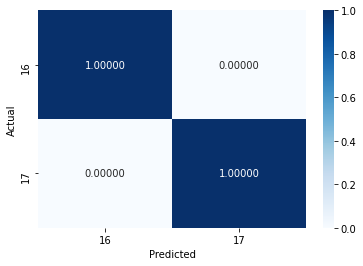

In [36]:
show_confusion_matrix(y_test, y_pred, DATASETS)
